In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [299]:
df = pd.read_csv("winequality-red.csv")
df = df.drop_duplicates()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


In [300]:
df['quality'].value_counts()

quality
5    577
6    535
7    167
4     53
8     17
3     10
Name: count, dtype: int64

In [301]:
# 8 and 3 are clearly underrepresented, so it might be better to remove those
# Let's only take 4-7
remaining_qualities = [4,5,6,7]
df = df[df['quality'].isin(remaining_qualities)]
df['quality'].value_counts()

quality
5    577
6    535
7    167
4     53
Name: count, dtype: int64

In [302]:
# everything else except the target variable
X = df.drop("quality", axis=1)

# have only the target variable here (dependent variable)
y = df['quality']

# Normalization
#X_mm = MinMaxScaler().fit_transform(X)

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [303]:
# As always, train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [304]:
# save the categories into a list
categories = list(np.unique(df['quality']))
print(categories)

# df['price_range'] = df['price_range'].replace({0: "1: Cheap", 1: "2: Avg-", 2: "3: Avg+", 3: "4: Expensive"})

[4, 5, 6, 7]


In [305]:
# First version of the neural network
# No optimisations, probably won't work well
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l1_l2()),
        layers.Dropout(0.1),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_16 (Ba  (None, 11)                44        
 tchNormalization)                                               
                                                                 
 dense_86 (Dense)            (None, 64)                768       
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_87 (Dense)            (None, 32)                2080      
                                                                 
 dropout_29 (Dropout)        (None, 32)                0         
                                                                 
 dense_88 (Dense)            (None, 16)                528       
                                                     

In [306]:
# Epochs can be adjusted
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200


34/34 [==============================] - 2s 12ms/step - loss: 2.4123 - accuracy: 0.3324 - val_loss: 2.1515 - val_accuracy: 0.5038
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 2.0260 - accuracy: 0.5202 - val_loss: 1.9571 - val_accuracy: 0.4361
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 1.7339 - accuracy: 0.5643 - val_loss: 1.8680 - val_accuracy: 0.4135
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 1.5295 - accuracy: 0.5775 - val_loss: 1.7886 - val_accuracy: 0.4060
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 1.3942 - accuracy: 0.5887 - val_loss: 1.5666 - val_accuracy: 0.4812
Epoch 6/200
34/34 [==============================] - 0s 3ms/step - loss: 1.2839 - accuracy: 0.5718 - val_loss: 1.3992 - val_accuracy: 0.4962
Epoch 7/200
34/34 [==============================] - 0s 5ms/step - loss: 1.1843 - accuracy: 0.6038 - val_loss: 1.2743 - val_accuracy: 0.5489
Epoch 8/200
34/34 [=====

<Axes: >

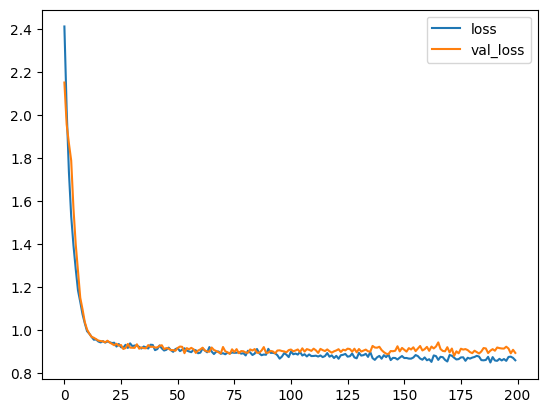

In [307]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

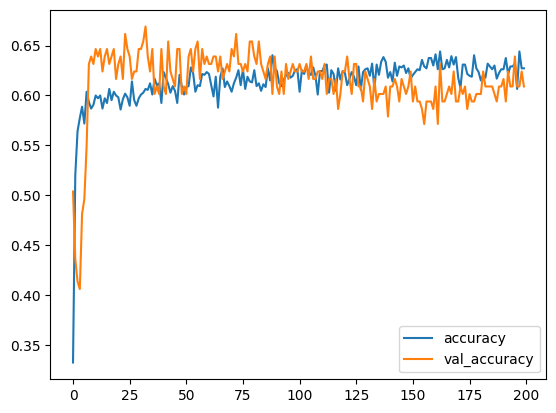

In [308]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [309]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[1.0495872497558594, 0.5522388219833374]

Train data evaluation:
[0.8179137110710144, 0.6647887229919434]


In [310]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

5/5 [==============================] - 0s 2ms/step


<Axes: >

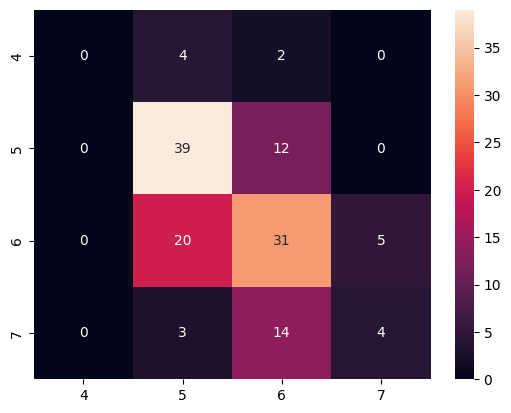

In [311]:
# Original heatmap without label names
# sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

# you can also use the actual names for the categories
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

In [312]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.59      0.76      0.67        51
           2       0.53      0.55      0.54        56
           3       0.44      0.19      0.27        21

    accuracy                           0.55       134
   macro avg       0.39      0.38      0.37       134
weighted avg       0.51      0.55      0.52       134


Model overall accuracy: 55.22%


c:\Users\tomco\Desktop\Various Things\Engineering Study\Semester Spring 2024\Deep Learning\DeepLearning2024\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tomco\Desktop\Various Things\Engineering Study\Semester Spring 2024\Deep Learning\DeepLearning2024\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tomco\Desktop\Various Things\Engineering Study\Semester Spring 2024\Deep Learning\DeepLearning2024\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: Undefined

In [313]:
# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

 1/42 [..............................] - ETA: 1s

42/42 [==============================] - 0s 3ms/step


0.8312057966339037